In [2]:
import rasterio 
import rasterio.mask
import geopandas as gpd
import fiona
import os
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import plot, show, savefig, xlim, figure, \
                 ylim, legend, boxplot, setp, axes
import matplotlib.patches as mpatches
import matplotlib as mpl

def mkdir(dir):
    
    if not os.path.exists(dir):
        os.mkdir(dir)
        
path_run = os.getcwd() + '/'
path_data_processed = path_run + 'data_processed/'
path_plots = path_run + 'plots/'
path_plots_creator = mkdir(path_plots)

results = pd.DataFrame()

for filename in sorted(os.listdir(f"{path_data_processed}affected_people/")):
    print(filename)
    results_temp = pd.read_csv(f"{path_data_processed}affected_people/" + filename)
    results = results.append(results_temp)

/home/mester/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


results_max_100_wind_final.csv
results_max_10_wind_final.csv
results_max_50_wind_final.csv
results_mean_100_wind_final.csv
results_mean_10_wind_final.csv
results_mean_50_wind_final.csv
results_min_100_wind_final.csv
results_min_10_wind_final.csv
results_min_50_wind_final.csv
results_no_100_wind_final.csv
results_no_10_wind_final.csv
results_no_50_wind_final.csv


In [3]:
results['scenario'] = results['scenario'].str.replace('cf','factual')

displacements_IDMC = 478169

def cf_group(x):

        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind' or x == 'factualwind880' or x == 'factualwind915' or x == 'factualwind940':
            group = 2
            
        if 'factualwindzos' in x or 'factualwind880zos' in x or 'factualwind915zos' in x or 'factualwind940zos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))          
results_ext = pd.DataFrame()

for tide in ['no','mean','max','min']:
    
    for threshold in [10,50,100]:
#    for threshold in [100]:

        results_temp = results[results['tide']==tide]
        results_temp = results_temp[results_temp['threshold']==threshold]
        factual_temp_value = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp_value - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],4)

        results_temp['cf_group'] = results_temp['scenario'].apply(lambda x: cf_group(x))
        results_temp.loc[:,'affected_flood_wind'] = results_temp.loc[:,'affected'] + results_temp.loc[:,'affected_wind_96']
        results_temp.loc[:,'affected_flood_wind_cf'] = results_temp.loc[:,'affected'] + results_temp.loc[:,'affected_wind_96_cf']

        factual_temp = results_temp[results_temp['scenario']=='factual']
        factual_temp.loc[:,'displacements'] = displacements_IDMC

        non_factual_temp = results_temp[results_temp['scenario']!='factual']
        results_temp_remerged = factual_temp.append(non_factual_temp)
        results_temp_remerged.loc[:,'vulnerability'] = (factual_temp['displacements']/factual_temp['affected']).iloc[0]
        results_temp_remerged.loc[:,'displacements'] = round(results_temp_remerged['vulnerability']*results_temp_remerged['affected'],0)
        results_temp_remerged.loc[:,'displacements_dif'] = displacements_IDMC - results_temp_remerged['displacements']
        results_temp_remerged.loc[:,'displacements_dif_perc'] = np.round(100*results_temp_remerged['displacements_dif']/results_temp_remerged['displacements'],4)
        
        results_temp_remerged.loc[:,'vulnerability_flood_wind'] = (factual_temp['displacements']/factual_temp['affected_flood_wind']).iloc[0]
        results_temp_remerged.loc[:,'displacements_flood_wind_cf'] = round(results_temp_remerged['affected_flood_wind_cf'] * results_temp_remerged['vulnerability_flood_wind'],0)
        results_temp_remerged.loc[:,'displacements_flood_wind_cf_dif'] = displacements_IDMC - results_temp_remerged['displacements_flood_wind_cf'] 
        results_temp_remerged.loc[:,'displacements_flood_wind_cf_dif_perc_of_tot_disp'] = np.round(100*results_temp_remerged['displacements_flood_wind_cf_dif']/displacements_IDMC,4)
 
        results_ext = results_ext.append(results_temp_remerged)
        
results_ext.reset_index(inplace=True)                       
results_ext

/home/mester/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/mester/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/mester/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a c

,index,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,cf_group,...,affected_flood_wind,affected_flood_wind_cf,displacements,vulnerability,displacements_dif,displacements_dif_perc,vulnerability_flood_wind,displacements_flood_wind_cf,displacements_flood_wind_cf_dif,displacements_flood_wind_cf_dif_perc_of_tot_disp
0,0,factual,no,10,2050569,1141476.0,847139.0,121981.0,0.0,0,...,2172550.0,2050569.0,478169.0,0.233188,0.0,0.0000,0.220096,451322.0,26847.0,5.6145
1,1,factualwind880,no,10,1756972,1350089.0,1055278.0,325009.0,0.0,2,...,2081981.0,1756972.0,409706.0,0.233188,68463.0,16.7103,0.220096,386702.0,91467.0,19.1286
2,2,factualwind880zos065,no,10,1749105,1355560.0,1060537.0,329308.0,0.0,3,...,2078413.0,1749105.0,407871.0,0.233188,70298.0,17.2354,0.220096,384971.0,93198.0,19.4906
3,3,factualwind880zos070,no,10,1748892,1355773.0,1060750.0,329516.0,0.0,3,...,2078408.0,1748892.0,407821.0,0.233188,70348.0,17.2497,0.220096,384924.0,93245.0,19.5004
4,4,factualwind880zos075,no,10,1747160,1355773.0,1060750.0,329516.0,0.0,3,...,2076676.0,1747160.0,407418.0,0.233188,70751.0,17.3657,0.220096,384542.0,93627.0,19.5803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,108,factualzos150,min,100,1221721,1433554.0,1132161.0,355029.0,0.0,1,...,1576750.0,1221721.0,477804.0,0.391091,365.0,0.0764,0.303262,370502.0,107667.0,22.5165
1370,109,factualzos155,min,100,1221721,1433554.0,1132161.0,355029.0,0.0,1,...,1576750.0,1221721.0,477804.0,0.391091,365.0,0.0764,0.303262,370502.0,107667.0,22.5165
1371,110,factualzos160,min,100,1221721,1433554.0,1132161.0,355029.0,0.0,1,...,1576750.0,1221721.0,477804.0,0.391091,365.0,0.0764,0.303262,370502.0,107667.0,22.5165
1372,111,factualzos165,min,100,1221721,1433554.0,1132161.0,355029.0,0.0,1,...,1576750.0,1221721.0,477804.0,0.391091,365.0,0.0764,0.303262,370502.0,107667.0,22.5165


In [3]:
results_ext_900 = results_ext[~results_ext.scenario.str.contains("880")]
results_ext_900 = results_ext_900[~results_ext_900.scenario.str.contains("915")]
results_ext_900 = results_ext_900[~results_ext_900.scenario.str.contains("940")]

In [4]:
results_ext.to_csv(path_data_processed + 'all_results.csv')

In [35]:
# flooding

print('flooding \n')
print('Max Tide:','\n')
results_ext_900_temp = results_ext_900[results_ext_900['tide']=='max']
results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['threshold']==100]
results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['cf_group']==3]

print('Min. % change for max:',round(np.min(results_ext_900_temp['affected_dif_perc']),1))
print('5th quantile % change for max:',round(results_ext_900_temp['affected_dif_perc'].quantile(0.05),1))
print('Median % change for max:',round(np.median(results_ext_900_temp['affected_dif_perc']),1))
print('95th quantile % change for max:',round(results_ext_900_temp['affected_dif_perc'].quantile(0.95),1))
print('Max. % change for max:',round(np.max(results_ext_900_temp['affected_dif_perc']),1),'\n')

print('Min. change in displacements for max:',round(np.min(results_ext_900_temp['displacements_dif']),0))
print('Median change in displacements for max:',round(np.median(results_ext_900_temp['displacements_dif']),0))
print('Max. change in displacements for max:',round(np.max(results_ext_900_temp['displacements_dif']),0),'\n')
#print('Max. change in affected for max:',round(np.max(results_ext_900_temp['affected_dif']),-2),'\n')

results_ext_900_temp = results_ext[results_ext['tide']=='no']
results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['threshold']==100]
results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['cf_group']==3]

print('No Tide:','\n')
print('Min. % change for no:',round(np.min(results_ext_900_temp['affected_dif_perc']),1))
print('5th quantile % change for no:',round(results_ext_900_temp['affected_dif_perc'].quantile(0.05),1))
print('Median % change for no:',round(np.median(results_ext_900_temp['affected_dif_perc']),1))
print('95th quantile % change for no:',round(results_ext_900_temp['affected_dif_perc'].quantile(0.95),1))
print('Max. % change for no:',round(np.max(results_ext_900_temp['affected_dif_perc']),1),'\n')

print('Min. change in displacements for max:',round(np.min(results_ext_900_temp['displacements_dif']),0))
print('Median change in displacements for no:',round(np.median(results_ext_900_temp['displacements_dif']),0))
print('Max. change in displacements for no:',round(np.max(results_ext_900_temp['displacements_dif']),0),'\n')
#print('Max. change in affected for no:',round(np.max(results_ext_900_temp['affected_dif']),-2),'\n')

# all depth thresholds

print('All depth thresholds \n')

results_ext_900_temp = results_ext[results_ext['tide']=='max']
results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['cf_group']==3]

print('Max overall change in displacements:', round(np.max(results_ext_900_temp.sort_values('displacements_dif',ascending=False)['displacements_dif']),-2))                                                  
print('Max overall change in %:',round(np.max(results_ext_900_temp.sort_values('displacements_dif_perc',ascending=False)['displacements_dif_perc']),1),'\n')                                                
                              
    
# wind

print('wind - max tide \n')
results_ext_900_temp = results_ext[results_ext['tide']=='max']
results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['threshold']==100]
results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['cf_group']==3]

print("min number of affected:",round(np.min(results_ext_900_temp.sort_values('affected_wind_96',ascending=False)['affected_wind_96']),-2))
print("max number of affected:",round(np.max(results_ext_900_temp.sort_values('affected_wind_96',ascending=False)['affected_wind_96']),-2),'\n')

print('min number of displacements:',round(np.min(results_ext_900_temp.sort_values('displacements_flood_wind_cf_dif',ascending=False)['displacements_flood_wind_cf_dif']),-2))
print('max number of displacements:',round(np.max(results_ext_900_temp.sort_values('displacements_flood_wind_cf_dif',ascending=False)['displacements_flood_wind_cf_dif']),-2),'\n')


print("min % of all displacements:",round(np.min(results_ext_900_temp.sort_values('displacements_flood_wind_cf_dif_perc_of_tot_disp',ascending=False)['displacements_flood_wind_cf_dif_perc_of_tot_disp']),1))
print("max % of all displacements:",round(np.max(results_ext_900_temp.sort_values('displacements_flood_wind_cf_dif_perc_of_tot_disp',ascending=False)['displacements_flood_wind_cf_dif_perc_of_tot_disp']),1),'\n')

flooding 

Max Tide: 

Min. % change for max: 2.9
5th quantile % change for max: 2.9
Median % change for max: 3.0
95th quantile % change for max: 3.2
Max. % change for max: 3.2 

Min. change in displacements for max: 13331.0
Median change in displacements for max: 13958.0
Max. change in displacements for max: 14875.0 

No Tide: 

Min. % change for no: 2.6
5th quantile % change for no: 2.6
Median % change for no: 3.2
95th quantile % change for no: 3.4
Max. % change for no: 3.4 

Min. change in displacements for max: 11991.0
Median change in displacements for no: 14758.0
Max. change in displacements for no: 15750.0 

All depth thresholds 

Max overall change in displacements: 56500.0
Max overall change in %: 13.4 

wind - max tide 

min number of affected: 340900.0
max number of affected: 360600.0 

min number of displacements: 103700.0
max number of displacements: 112100.0 

min % of all displacements: 21.7
max % of all displacements: 23.4 



# Plot

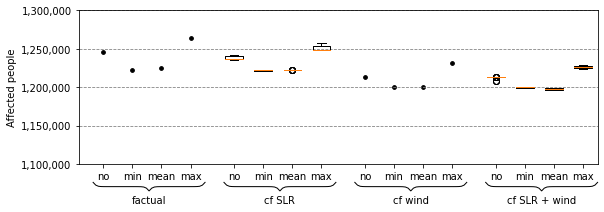

In [12]:
# Affected people - 100 cm

fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(3)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Affected people')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_ext_900_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==0]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected']))
        
    plt.scatter([0,1,2,3],results_ext_900_temp_list,color='black',s=14)

    # second boxplot pair
    results_ext_900_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==1]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected']))

    bp_2 = boxplot(results_ext_900_temp_list,positions = [4.5,5.5,6.5,7.5],widths = 0.6)

    # third boxplot pair
    results_ext_900_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==2]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected']))

    plt.scatter([9,10,11,12],results_ext_900_temp_list,color='black',s=14)
    
    results_ext_900_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==3]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected']))

    bp_3 = boxplot(results_ext_900_temp_list,positions = [13.5,14.5,15.5,16.5],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12, 13.5,14.5,15.5,16.5])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .015)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.01*yspan, text, ha='center', va='bottom')
    dif = -1061000
    draw_brace(ax1, (-0.35,3.5),dif, 'factual')
    draw_brace(ax1, (4.15,8.0),dif, 'cf SLR')
    draw_brace(ax1, (8.65,12.5),dif, 'cf wind')
    draw_brace(ax1, (13.15,17),dif, 'cf SLR + wind')

    ylim(1_100_000,1_300_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    

fig.tight_layout()

fig.savefig(f"{path_plots}/plot_all_tides_affected_people_100.png",dpi=300)

In [106]:
results_ext_900

,index,Unnamed: 0,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,...,affected_flood_wind,affected_flood_wind_cf,displacements,vulnerability,displacements_dif,displacements_dif_perc,vulnerability_flood_wind,displacements_flood_wind_cf,displacements_flood_wind_cf_dif,displacements_flood_wind_cf_dif_perc_of_tot_disp
0,0,NaN,factual,no,100,1246043,1415531.0,1114235.0,337522.0,0.0,...,1583565.0,1246043.0,478169.0,0.383750,0.0,0.0000,0.301957,376252.0,101917.0,21.3140
70,70,NaN,factualwind,no,100,1213819,1440771.0,1139447.0,361724.0,0.0,...,1575543.0,1213819.0,465803.0,0.383750,12366.0,2.6548,0.301957,366521.0,111648.0,23.3491
71,71,NaN,factualwindzos065,no,100,1213157,1441047.0,1139464.0,361741.0,0.0,...,1574898.0,1213157.0,465549.0,0.383750,12620.0,2.7108,0.301957,366322.0,111847.0,23.3907
72,72,NaN,factualwindzos070,no,100,1213140,1441063.0,1139481.0,361758.0,0.0,...,1574898.0,1213140.0,465542.0,0.383750,12627.0,2.7123,0.301957,366316.0,111853.0,23.3919
73,73,NaN,factualwindzos075,no,100,1213140,1441063.0,1139481.0,361758.0,0.0,...,1574898.0,1213140.0,465542.0,0.383750,12627.0,2.7123,0.301957,366316.0,111853.0,23.3919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,108,NaN,factualzos150,min,100,1221721,1433554.0,1132161.0,355029.0,0.0,...,1576750.0,1221721.0,477804.0,0.391091,365.0,0.0764,0.303262,370502.0,107667.0,22.5165
454,109,NaN,factualzos155,min,100,1221721,1433554.0,1132161.0,355029.0,0.0,...,1576750.0,1221721.0,477804.0,0.391091,365.0,0.0764,0.303262,370502.0,107667.0,22.5165
455,110,NaN,factualzos160,min,100,1221721,1433554.0,1132161.0,355029.0,0.0,...,1576750.0,1221721.0,477804.0,0.391091,365.0,0.0764,0.303262,370502.0,107667.0,22.5165
456,111,NaN,factualzos165,min,100,1221721,1433554.0,1132161.0,355029.0,0.0,...,1576750.0,1221721.0,477804.0,0.391091,365.0,0.0764,0.303262,370502.0,107667.0,22.5165


In [108]:
results_ext_900

,index,Unnamed: 0,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,...,affected_flood_wind,affected_flood_wind_cf,displacements,vulnerability,displacements_dif,displacements_dif_perc,vulnerability_flood_wind,displacements_flood_wind_cf,displacements_flood_wind_cf_dif,displacements_flood_wind_cf_dif_perc_of_tot_disp
0,0,NaN,factual,no,100,1246043,1415531.0,1114235.0,337522.0,0.0,...,1583565.0,1246043.0,478169.0,0.383750,0.0,0.0000,0.301957,376252.0,101917.0,21.3140
70,70,NaN,factualwind,no,100,1213819,1440771.0,1139447.0,361724.0,0.0,...,1575543.0,1213819.0,465803.0,0.383750,12366.0,2.6548,0.301957,366521.0,111648.0,23.3491
71,71,NaN,factualwindzos065,no,100,1213157,1441047.0,1139464.0,361741.0,0.0,...,1574898.0,1213157.0,465549.0,0.383750,12620.0,2.7108,0.301957,366322.0,111847.0,23.3907
72,72,NaN,factualwindzos070,no,100,1213140,1441063.0,1139481.0,361758.0,0.0,...,1574898.0,1213140.0,465542.0,0.383750,12627.0,2.7123,0.301957,366316.0,111853.0,23.3919
73,73,NaN,factualwindzos075,no,100,1213140,1441063.0,1139481.0,361758.0,0.0,...,1574898.0,1213140.0,465542.0,0.383750,12627.0,2.7123,0.301957,366316.0,111853.0,23.3919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,108,NaN,factualzos150,min,100,1221721,1433554.0,1132161.0,355029.0,0.0,...,1576750.0,1221721.0,477804.0,0.391091,365.0,0.0764,0.303262,370502.0,107667.0,22.5165
454,109,NaN,factualzos155,min,100,1221721,1433554.0,1132161.0,355029.0,0.0,...,1576750.0,1221721.0,477804.0,0.391091,365.0,0.0764,0.303262,370502.0,107667.0,22.5165
455,110,NaN,factualzos160,min,100,1221721,1433554.0,1132161.0,355029.0,0.0,...,1576750.0,1221721.0,477804.0,0.391091,365.0,0.0764,0.303262,370502.0,107667.0,22.5165
456,111,NaN,factualzos165,min,100,1221721,1433554.0,1132161.0,355029.0,0.0,...,1576750.0,1221721.0,477804.0,0.391091,365.0,0.0764,0.303262,370502.0,107667.0,22.5165


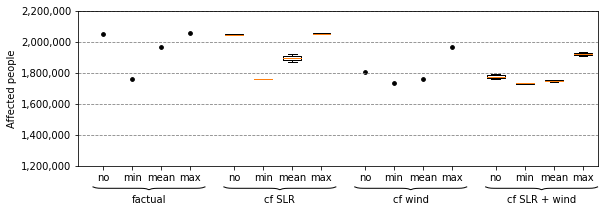

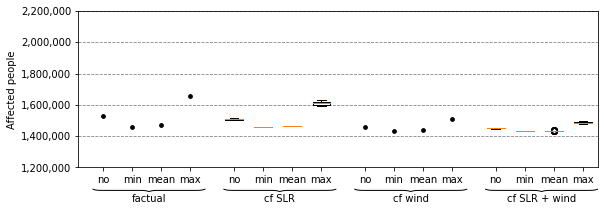

In [13]:
# Affected people - 10 cm / 50 cm

threshold_counter = 0

for threshold in [10,50]:
    fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)

    ax1.set_ylabel('Affected people')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_ext_900_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==0]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected']))
    
    plt.scatter([0,1,2,3],results_ext_900_temp_list,color='black',s=14)

    # second boxplot pair
    results_ext_900_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==1]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected']))

    bp_2 = boxplot(results_ext_900_temp_list,positions = [4.5,5.5,6.5,7.5],widths = 0.6)

    # third boxplot pair
    results_ext_900_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==2]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected']))

    plt.scatter([9,10,11,12],results_ext_900_temp_list,color='black',s=14)
    
    results_ext_900_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==3]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected']))

    bp_3 = boxplot(results_ext_900_temp_list,positions = [13.5,14.5,15.5,16.5],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12, 13.5,14.5,15.5,16.5])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .015)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.04*yspan, text, ha='center', va='bottom')
    dif = -1040000
    draw_brace(ax1, (-0.35,3.5),dif, 'factual')
    draw_brace(ax1, (4.15,8.0),dif, 'cf SLR')
    draw_brace(ax1, (8.65,12.5),dif, 'cf wind')
    draw_brace(ax1, (13.15,17),dif, 'cf SLR + wind')

    ylim(1_200_000,2_200_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    

    fig.tight_layout()

    fig.savefig(f"{path_plots}/plot_all_tides_affected_people_{threshold}.png",dpi=300)

In [111]:
results_ext_900_temp#[results_ext_900_temp['scenario']=='factual']#['affected']

,index,Unnamed: 0,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,...,affected_flood_wind,affected_flood_wind_cf,displacements,vulnerability,displacements_dif,displacements_dif_perc,vulnerability_flood_wind,displacements_flood_wind_cf,displacements_flood_wind_cf_dif,displacements_flood_wind_cf_dif_perc_of_tot_disp


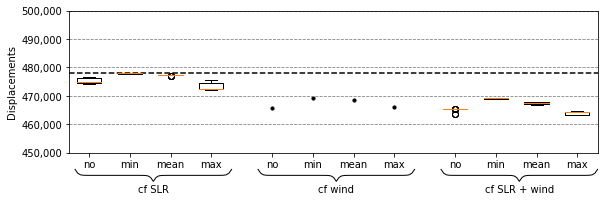

In [14]:
# Displacements - 100 cm

for threshold in [100]:
    
    fig = plt.figure(figsize =(8.5,3.0), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(1, 1, 1)

    ax1.set_ylabel('Displacements')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_ext_900_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==1]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['displacements']))
        
    bp_1 = boxplot(results_ext_900_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_ext_900_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==2]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['displacements']))

    plt.scatter([4.5,5.5,6.5,7.5],results_ext_900_temp_list,color='black',s=10)

    # third boxplot pair
    results_ext_900_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==3]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['displacements']))
        
    bp_3 = boxplot(results_ext_900_temp_list,positions = [9,10,11,12],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.011*yspan, text, ha='center', va='bottom')
        
    dif = -441000
    draw_brace(ax1, (-0.35,3.5),dif, 'cf SLR')
    draw_brace(ax1, (4.15,8.0),dif, 'cf wind')
    draw_brace(ax1, (8.65,12.5),dif, 'cf SLR + wind')

    ylim(450_000,500_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    
    ax1.axhline(y=478169, color='black', linestyle='--')
    
    fig.tight_layout()

    fig.savefig(f"{path_plots}/plot_all_tides_displacements_{threshold}.png",dpi=300)

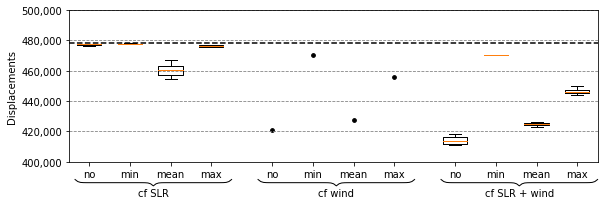

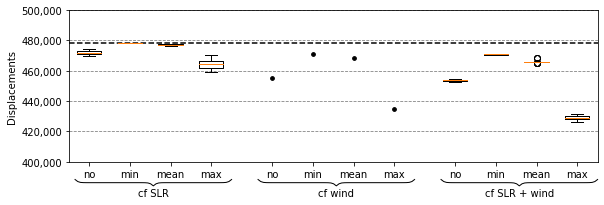

In [15]:
# Displacements - 10 cm / 50 cm

for threshold in [10,50]:
    
    fig = plt.figure(figsize =(8.5,3.0), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_ylabel('Displacements')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_ext_900_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]
        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==1]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['displacements']))
        
    bp_1 = boxplot(results_ext_900_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_ext_900_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==2]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['displacements']))

    plt.scatter([4.5,5.5,6.5,7.5],results_ext_900_temp_list,color='black',s=14)

    # third boxplot pair
    results_ext_900_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==3]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['displacements']))
        
    bp_3 = boxplot(results_ext_900_temp_list,positions = [9,10,11,12],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')

    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.017*yspan, text, ha='center', va='bottom')
        
    dif = -385000
    draw_brace(ax1, (-0.35,3.5),dif, 'cf SLR')
    draw_brace(ax1, (4.15,8.0),dif, 'cf wind')
    draw_brace(ax1, (8.65,12.5),dif, 'cf SLR + wind')

    ylim(400_000,500_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    
    ax1.axhline(y=478169, color='black', linestyle='--')

    fig.tight_layout()

    fig.savefig(f"{path_plots}/plot_all_tides_displacements_{threshold}.png",dpi=300)

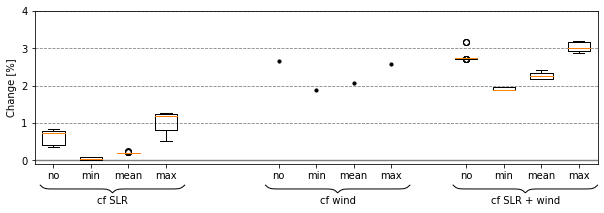

In [16]:
# Change affected people - 100 cm

fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(1)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    results_ext_900_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]
        results_ext_900_temp.loc[:,'affected_dif'] = factual_temp - results_ext_900_temp['affected']
        results_ext_900_temp.loc[:,'affected_dif_perc'] = np.round(100*results_ext_900_temp['affected_dif']/results_ext_900_temp['affected'],2)

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==1]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected_dif_perc']))
        


    bp_1 = boxplot(results_ext_900_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_ext_900_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]
        results_ext_900_temp.loc[:,'affected_dif'] = factual_temp - results_ext_900_temp['affected']
        results_ext_900_temp.loc[:,'affected_dif_perc'] = np.round(100*results_ext_900_temp['affected_dif']/results_ext_900_temp['affected'],2)

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==2]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected_dif_perc']))

    plt.scatter([6,7,8,9],results_ext_900_temp_list,color='black',s=10)


    # third boxplot pair
    results_ext_900_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]
        results_ext_900_temp.loc[:,'affected_dif'] = factual_temp - results_ext_900_temp['affected']
        results_ext_900_temp.loc[:,'affected_dif_perc'] = np.round(100*results_ext_900_temp['affected_dif']/results_ext_900_temp['affected'],2)

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==3]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected_dif_perc']))

    bp_3 = boxplot(results_ext_900_temp_list,positions = [11,12,13,14],widths = 0.6)

    ylim(-0.1,4)
    
    ax1.set_xticks([0,1,2,3, 6,7,8,9, 11,12,13,14])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.15*yspan, text, ha='center', va='bottom')

    draw_brace(ax1, (-0.35,3.5),0.6, 'cf SLR')
    draw_brace(ax1, (5.65,9.5),0.6, 'cf wind')
    draw_brace(ax1, (10.65,14.5),0.6, 'cf SLR + wind')
    
fig.tight_layout()

fig.savefig(f"{path_plots}/plot_all_tides_affected_people_change_100.png",dpi=300)

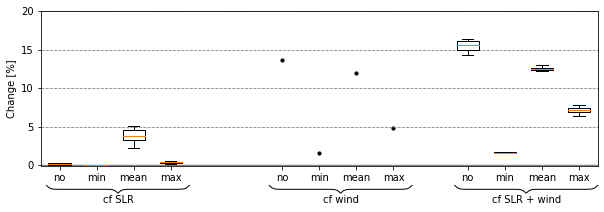

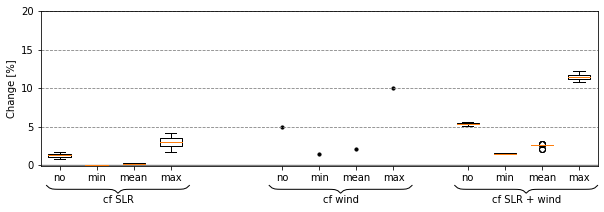

In [17]:
# Change affected people - 10 cm / 50 cm

for threshold in [10,50]:
    fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_ext_900_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]
        results_ext_900_temp.loc[:,'affected_dif'] = factual_temp - results_ext_900_temp['affected']
        results_ext_900_temp.loc[:,'affected_dif_perc'] = np.round(100*results_ext_900_temp['affected_dif']/results_ext_900_temp['affected'],2)

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==1]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected_dif_perc']))
        
    bp_1 = boxplot(results_ext_900_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_ext_900_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]
        results_ext_900_temp.loc[:,'affected_dif'] = factual_temp - results_ext_900_temp['affected']
        results_ext_900_temp.loc[:,'affected_dif_perc'] = np.round(100*results_ext_900_temp['affected_dif']/results_ext_900_temp['affected'],2)

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==2]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected_dif_perc']))

    plt.scatter([6,7,8,9],results_ext_900_temp_list,color='black',s=10)

    # third boxplot pair
    results_ext_900_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_ext_900_temp = results_ext_900[results_ext_900['threshold']==threshold]
        results_ext_900_temp = results_ext_900_temp[results_ext_900_temp['tide']==tide]

        factual_temp = results_ext_900_temp[results_ext_900_temp['scenario']=='factual']['affected'].iloc[0]
        results_ext_900_temp.loc[:,'affected_dif'] = factual_temp - results_ext_900_temp['affected']
        results_ext_900_temp.loc[:,'affected_dif_perc'] = np.round(100*results_ext_900_temp['affected_dif']/results_ext_900_temp['affected'],2)

        results_ext_900_temp_cf_group = results_ext_900_temp[results_ext_900_temp['cf_group']==3]
        results_ext_900_temp_list.append(list(results_ext_900_temp_cf_group['affected_dif_perc']))

    bp_3 = boxplot(results_ext_900_temp_list,positions = [11,12,13,14],widths = 0.6)

    ylim(-0.1,20)
    
    ax1.set_xticks([0,1,2,3, 6,7,8,9, 11,12,13,14])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y + .05)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.20*yspan, text, ha='center', va='bottom')
        
    dif = 1.1
    draw_brace(ax1, (-0.35,3.5),dif, 'cf SLR')
    draw_brace(ax1, (5.65,9.5),dif, 'cf wind')
    draw_brace(ax1, (10.65,14.5),dif, 'cf SLR + wind')

    fig.tight_layout()

    fig.savefig(f"{path_plots}/plot_all_tides_affected_people_change_{threshold}.png",dpi=300)

# Table results

In [6]:
# new plot!


results_temp_list = []


for tide in ['no','min','mean','max']:

    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']==tide]
    

results_temp = results_temp[results_temp['cf_group']==3]
results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

results_temp_list


[301    2.8678
 302    2.9211
 303    2.9149
 304    2.9258
 305    2.9309
 306    2.9406
 307    2.9460
 308    2.9755
 309    2.9737
 310    2.9849
 311    2.9870
 312    3.0266
 313    3.0266
 314    3.0565
 315    3.0565
 316    3.1487
 317    3.1942
 318    3.1964
 319    3.1964
 320    3.1964
 321    3.2065
 322    3.2107
 Name: affected_dif_perc, dtype: float64, 232    3.2795
 233    3.2966
 234    3.3116
 235    3.3274
 236    3.5165
 237    3.5216
 238    3.5591
 239    3.5591
 240    3.6414
 241    3.6420
 242    3.6571
 243    3.7578
 244    3.7710
 245    3.8805
 246    3.9366
 247    3.9401
 248    3.9459
 249    3.9575
 250    3.9580
 251    3.9597
 252    3.9639
 253    3.9639
 Name: affected_dif_perc, dtype: float64, 255    2.4439
 256    2.5380
 257    2.5889
 258    2.6002
 259    2.6335
 260    2.7042
 261    2.7108
 262    2.7498
 263    2.7534
 264    2.7559
 265    2.8730
 266    2.8985
 267    2.8985
 268    2.9404
 269    2.9556
 270    2.9614
 271    2.9843
 27

In [27]:
# Table results #1 - cf SLR - displacements - 10%

threshold_lst = []
inten_lst = []
tide_lst = []
disp_min_lst = []
disp_median_lst = []
disp_max_lst = []
perc_min_lst = []
perc_median_lst = []
perc_max_lst = []

for threshold_temp in [10,50,100]:
    
    for inten_temp in ['factualzos']:

        for tide_temp in ['no','min','mean','max']:

            results_temp = results_ext[results_ext['threshold']==threshold_temp]
            results_temp = results_temp[results_temp['tide']==tide_temp]
            results_temp = results_temp[results_temp.scenario.str.contains(inten_temp)]
            
            threshold_lst.append(threshold_temp)
            inten_lst.append(inten_temp)
            tide_lst.append(tide_temp)
            
            disp_min_lst.append(int(results_temp['displacements_dif'].min()))
            disp_median_lst.append(int(results_temp['displacements_dif'].median()))
            disp_max_lst.append(int(results_temp['displacements_dif'].max()))
            perc_min_lst.append(np.round(results_temp['affected_dif_perc'].min(),1))
            perc_median_lst.append(np.round(results_temp['affected_dif_perc'].median(),1))
            perc_max_lst.append(np.round(results_temp['affected_dif_perc'].max(),1))
 
results_overview = pd.DataFrame()
results_overview['Flood Depth Threshold [cm]'] = threshold_lst
results_overview['Intensification [%]'] = inten_lst
results_overview['Tide'] = tide_lst
results_overview['Displacements Dif. Min.'] = disp_min_lst
results_overview['Displacements Dif. Median'] = disp_median_lst
results_overview['Displacements Dif. Max'] = disp_max_lst
results_overview['Displacements Dif. Min. [%]'] = perc_min_lst
results_overview['Displacements Dif. Median [%]'] = perc_median_lst
results_overview['Displacements Dif. Max [%]'] = perc_max_lst

results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('factualzos','10')

results_overview

,Flood Depth Threshold [cm],Intensification [%],Tide,Displacements Dif. Min.,Displacements Dif. Median,Displacements Dif. Max,Displacements Dif. Min. [%],Displacements Dif. Median [%],Displacements Dif. Max [%]
0,10,10,no,404,724,1530,0.1,0.2,0.3
1,10,10,min,123,259,309,0.0,0.1,0.1
2,10,10,mean,10770,17615,23408,2.3,3.8,5.1
3,10,10,max,851,1768,2494,0.2,0.4,0.5
4,50,10,no,3626,6215,8277,0.8,1.3,1.8
5,50,10,min,1,1,32,0.0,0.0,0.0
6,50,10,mean,724,947,1564,0.2,0.2,0.3
7,50,10,max,7841,13774,19306,1.7,3.0,4.2
8,100,10,no,1698,3440,4032,0.4,0.7,0.9
9,100,10,min,0,182,365,0.0,0.0,0.1


In [9]:
# Table results #1 - cf SLR - affected - 10%

threshold_lst = []
inten_lst = []
tide_lst = []
disp_min_lst = []
disp_median_lst = []
disp_max_lst = []
perc_min_lst = []
perc_median_lst = []
perc_max_lst = []

for threshold_temp in [10,50,100]:
    
    for inten_temp in ['factualzos']:

        for tide_temp in ['no','min','mean','max']:

            results_temp = results_ext[results_ext['threshold']==threshold_temp]
            results_temp = results_temp[results_temp['tide']==tide_temp]
            results_temp = results_temp[results_temp.scenario.str.contains(inten_temp)]
            
            threshold_lst.append(threshold_temp)
            inten_lst.append(inten_temp)
            tide_lst.append(tide_temp)
            
            disp_min_lst.append(int(results_temp['affected_dif'].min()))
            disp_median_lst.append(int(results_temp['affected_dif'].median()))
            disp_max_lst.append(int(results_temp['affected_dif'].max()))
            perc_min_lst.append(np.round(results_temp['affected_dif_perc'].min(),1))
            perc_median_lst.append(np.round(results_temp['affected_dif_perc'].median(),1))
            perc_max_lst.append(np.round(results_temp['affected_dif_perc'].max(),1))
 
results_overview = pd.DataFrame()
results_overview['Flood Depth Threshold [cm]'] = threshold_lst
results_overview['Intensification [%]'] = inten_lst
results_overview['Tide'] = tide_lst
results_overview['Displacements Dif. Min.'] = disp_min_lst
results_overview['Displacements Dif. Median'] = disp_median_lst
results_overview['Displacements Dif. Max'] = disp_max_lst
results_overview['Displacements Dif. Min. [%]'] = perc_min_lst
results_overview['Displacements Dif. Median [%]'] = perc_median_lst
results_overview['Displacements Dif. Max [%]'] = perc_max_lst

results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('factualzos','10')

results_overview

,Flood Depth Threshold [cm],Intensification [%],Tide,Displacements Dif. Min.,Displacements Dif. Median,Displacements Dif. Max,Displacements Dif. Min. [%],Displacements Dif. Median [%],Displacements Dif. Max [%]
0,10,10,no,1731,3104,6561,0.1,0.2,0.3
1,10,10,min,453,956,1139,0.0,0.1,0.1
2,10,10,mean,44382,72590,96460,2.3,3.8,5.1
3,10,10,max,3670,7620,10750,0.2,0.4,0.5
4,50,10,no,11592,19872,26465,0.8,1.3,1.8
5,50,10,min,3,3,97,0.0,0.0,0.0
6,50,10,mean,2223,2911,4804,0.2,0.2,0.3
7,50,10,max,27184,47759,66936,1.7,3.0,4.2
8,100,10,no,4425,8965,10508,0.4,0.7,0.9
9,100,10,min,0,467,934,0.0,0.0,0.1


In [10]:
# Table results #2 - cf wind - displacements - 10%

threshold_lst = []
inten_lst = []
tide_lst = []
disp_min_lst = []
disp_median_lst = []
disp_max_lst = []
perc_min_lst = []
perc_median_lst = []
perc_max_lst = []

for threshold_temp in [10,50,100]:
    
    for inten_temp in ['factualwind']:

        for tide_temp in ['no','min','mean','max']:

            results_temp = results_ext[results_ext['threshold']==threshold_temp]
            results_temp = results_temp[results_temp['tide']==tide_temp]
            results_temp = results_temp[results_temp.scenario == inten_temp]
            
            threshold_lst.append(threshold_temp)
            inten_lst.append(inten_temp)
            tide_lst.append(tide_temp)
            
            disp_median_lst.append(int(results_temp['displacements_dif'].median()))
            perc_median_lst.append(np.round(results_temp['affected_dif_perc'].median(),1))
 
results_overview = pd.DataFrame()
results_overview['Flood Depth Threshold [cm]'] = threshold_lst
results_overview['Intensification [%]'] = inten_lst
results_overview['Tide'] = tide_lst
results_overview['Displacements Dif.'] = disp_median_lst
results_overview['Displacements Dif. [%]'] = perc_median_lst

results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('windzos','10')

results_overview

,Flood Depth Threshold [cm],Intensification [%],Tide,Displacements,Displacements Dif. [%]
0,10,factualwind,no,57540,13.7
1,10,factualwind,min,7736,1.6
2,10,factualwind,mean,50899,11.9
3,10,factualwind,max,22067,4.8
4,50,factualwind,no,22703,5.0
5,50,factualwind,min,7182,1.5
6,50,factualwind,mean,9981,2.1
7,50,factualwind,max,43670,10.1
8,100,factualwind,no,12366,2.7
9,100,factualwind,min,8822,1.9


In [10]:
# Table results #2 - cf wind - affected - 10%

threshold_lst = []
inten_lst = []
tide_lst = []
disp_min_lst = []
disp_median_lst = []
disp_max_lst = []
perc_min_lst = []
perc_median_lst = []
perc_max_lst = []

for threshold_temp in [10,50,100]:
    
    for inten_temp in ['factualwind']:

        for tide_temp in ['no','min','mean','max']:

            results_temp = results_ext[results_ext['threshold']==threshold_temp]
            results_temp = results_temp[results_temp['tide']==tide_temp]
            results_temp = results_temp[results_temp.scenario == inten_temp]
            
            threshold_lst.append(threshold_temp)
            inten_lst.append(inten_temp)
            tide_lst.append(tide_temp)
            
            disp_median_lst.append(int(results_temp['affected_dif'].median()))
            perc_median_lst.append(np.round(results_temp['affected_dif_perc'].median(),1))
 
results_overview = pd.DataFrame()
results_overview['Flood Depth Threshold [cm]'] = threshold_lst
results_overview['Intensification [%]'] = inten_lst
results_overview['Tide'] = tide_lst
results_overview['Displacements Dif.'] = disp_median_lst
results_overview['Displacements Dif. [%]'] = perc_median_lst

results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('windzos','10')

results_overview

,Flood Depth Threshold [cm],Intensification [%],Tide,Displacements Dif.,Displacements Dif. [%]
0,10,factualwind,no,246752,13.7
1,10,factualwind,min,28499,1.6
2,10,factualwind,mean,209745,11.9
3,10,factualwind,max,95122,4.8
4,50,factualwind,no,72588,5.0
5,50,factualwind,min,21882,1.5
6,50,factualwind,mean,30653,2.1
7,50,factualwind,max,151408,10.1
8,100,factualwind,no,32224,2.7
9,100,factualwind,min,22557,1.9


In [26]:
results_ext.columns

Index(['index', 'scenario', 'tide', 'threshold', 'affected',
       'affected_wind_64', 'affected_wind_64_cf', 'affected_wind_96',
       'affected_wind_96_cf', 'cf_group', 'affected_dif', 'affected_dif_perc',
       'affected_flood_wind', 'affected_flood_wind_cf', 'displacements',
       'vulnerability', 'displacements_dif', 'displacements_dif_perc',
       'vulnerability_flood_wind', 'displacements_flood_wind_cf',
       'displacements_flood_wind_cf_dif',
       'displacements_flood_wind_cf_dif_perc_of_tot_disp'],
      dtype='object')

In [ ]:
# Table results #4 - cf SLR + wind - displacements - 10%

threshold_lst = []
inten_lst = []
tide_lst = []
disp_min_lst = []
disp_median_lst = []
disp_max_lst = []
perc_min_lst = []
perc_median_lst = []
perc_max_lst = []

for threshold_temp in [10,50,100]:
    
    for inten_temp in ['windzos']:

        for tide_temp in ['no','min','mean','max']:

            results_temp = results_ext[results_ext['threshold']==threshold_temp]
            results_temp = results_temp[results_temp['tide']==tide_temp]
            results_temp = results_temp[results_temp.scenario.str.contains(inten_temp)]
            
            threshold_lst.append(threshold_temp)
            inten_lst.append(inten_temp)
            tide_lst.append(tide_temp)
            
            disp_min_lst.append(int(results_temp['displacements_dif'].min()))
            disp_median_lst.append(int(results_temp['displacements_dif'].median()))
            disp_max_lst.append(int(results_temp['displacements_dif'].max()))
            perc_min_lst.append(np.round(results_temp['affected_dif_perc'].min(),1))
            perc_median_lst.append(np.round(results_temp['affected_dif_perc'].median(),1))
            perc_max_lst.append(np.round(results_temp['affected_dif_perc'].max(),1))
 
results_overview = pd.DataFrame()
results_overview['Flood Depth Threshold [cm]'] = threshold_lst
results_overview['Intensification [%]'] = inten_lst
results_overview['Tide'] = tide_lst
results_overview['Displacements Dif. Min.'] = disp_min_lst
results_overview['Displacements Dif. Median'] = disp_median_lst
results_overview['Displacements Dif. Max'] = disp_max_lst
results_overview['Displacements Dif. Min. [%]'] = perc_min_lst
results_overview['Displacements Dif. Median [%]'] = perc_median_lst
results_overview['Displacements Dif. Max [%]'] = perc_max_lst

results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('windzos','10')

results_overview

In [11]:
# Table results #3 - cf SLR + wind - affected - 10%

threshold_lst = []
inten_lst = []
tide_lst = []
disp_min_lst = []
disp_median_lst = []
disp_max_lst = []
perc_min_lst = []
perc_median_lst = []
perc_max_lst = []

for threshold_temp in [10,50,100]:
    
    for inten_temp in ['windzos']:

        for tide_temp in ['no','min','mean','max']:

            results_temp = results_ext[results_ext['threshold']==threshold_temp]
            results_temp = results_temp[results_temp['tide']==tide_temp]
            results_temp = results_temp[results_temp.scenario.str.contains(inten_temp)]
            
            threshold_lst.append(threshold_temp)
            inten_lst.append(inten_temp)
            tide_lst.append(tide_temp)
            
            disp_min_lst.append(int(results_temp['affected_dif'].min()))
            disp_median_lst.append(int(results_temp['affected_dif'].median()))
            disp_max_lst.append(int(results_temp['affected_dif'].max()))
            perc_min_lst.append(np.round(results_temp['affected_dif_perc'].min(),1))
            perc_median_lst.append(np.round(results_temp['affected_dif_perc'].median(),1))
            perc_max_lst.append(np.round(results_temp['affected_dif_perc'].max(),1))
 
results_overview = pd.DataFrame()
results_overview['Flood Depth Threshold [cm]'] = threshold_lst
results_overview['Intensification [%]'] = inten_lst
results_overview['Tide'] = tide_lst
results_overview['Affected Dif. Min.'] = disp_min_lst
results_overview['Affected Dif. Median'] = disp_median_lst
results_overview['Affected Dif. Max'] = disp_max_lst
results_overview['Affected Dif. Min. [%]'] = perc_min_lst
results_overview['Affected Dif. Median [%]'] = perc_median_lst
results_overview['Affected Dif. Max [%]'] = perc_max_lst

results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('windzos','10')

results_overview

,Flood Depth Threshold [cm],Intensification [%],Tide,Affected Dif. Min.,Affected Dif. Median,Affected Dif. Max,Affected Dif. Min. [%],Affected Dif. Median [%],Affected Dif. Max [%]
0,10,10,no,256743,277176,288376,14.3,15.6,16.4
1,10,10,min,28593,28594,29518,1.6,1.6,1.7
2,10,10,mean,213977,219468,227071,12.2,12.5,13.0
3,10,10,max,123102,138884,148528,6.4,7.2,7.8
4,50,10,no,74961,78664,81057,5.2,5.4,5.6
5,50,10,min,21882,21882,22805,1.5,1.5,1.6
6,50,10,mean,30671,38471,39131,2.1,2.7,2.7
7,50,10,max,161895,171054,181243,10.8,11.5,12.3
8,100,10,no,32886,33200,38121,2.7,2.7,3.2
9,100,10,min,22557,22557,23481,1.9,1.9,2.0


In [11]:
# Table results #5 - cf SLR + wind - displacements - 6%, 8.5% and 12%

threshold_lst = []
inten_lst = []
tide_lst = []
disp_min_lst = []
disp_median_lst = []
disp_max_lst = []
perc_min_lst = []
perc_median_lst = []
perc_max_lst = []

for tide_temp in ['no','max']:

    for threshold_temp in [10,50,100]:

        for inten_temp in ['940','915','880']:


            results_temp = results_ext[results_ext['threshold']==threshold_temp]
            results_temp = results_temp[results_temp['tide']==tide_temp]
            results_temp = results_temp[results_temp.scenario.str.contains(inten_temp)]
            
            threshold_lst.append(threshold_temp)
            inten_lst.append(inten_temp)
            tide_lst.append(tide_temp)
            
            disp_min_lst.append(int(results_temp['displacements_dif'].min()))
            disp_median_lst.append(int(results_temp['displacements_dif'].median()))
            disp_max_lst.append(int(results_temp['displacements_dif'].max()))
            perc_min_lst.append(np.round(results_temp['affected_dif_perc'].min(),1))
            perc_median_lst.append(np.round(results_temp['affected_dif_perc'].median(),1))
            perc_max_lst.append(np.round(results_temp['affected_dif_perc'].max(),1))
 
results_overview = pd.DataFrame()
results_overview['Flood Depth Threshold [cm]'] = threshold_lst
results_overview['Intensification [%]'] = inten_lst
results_overview['Tide'] = tide_lst
results_overview['Displacements Dif. Min.'] = disp_min_lst
results_overview['Displacements Dif. Median'] = disp_median_lst
results_overview['Displacements Dif. Max'] = disp_max_lst
results_overview['Displacements Dif. Min. [%]'] = perc_min_lst
results_overview['Displacements Dif. Median [%]'] = perc_median_lst
results_overview['Displacements Dif. Max [%]'] = perc_max_lst

results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('windzos','10')
results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('880','12')
results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('915','8.5')
results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('940','6')


results_overview

,Flood Depth Threshold [cm],Intensification [%],Tide,Displacements Min.,Displacements Median,Displacements Max,Displacements Dif. Min. [%],Displacements Dif. Median [%],Displacements Dif. Max [%]
0,10,6,no,28307,43083,49547,6.3,9.9,11.6
1,10,8.5,no,51897,59350,61094,12.2,14.2,14.6
2,10,12,no,68463,71418,72106,16.7,17.6,17.8
3,50,6,no,19687,22199,23205,4.3,4.9,5.1
4,50,8.5,no,22395,24083,24545,4.9,5.3,5.4
5,50,12,no,26799,27604,28280,5.9,6.1,6.3
6,100,6,no,11523,12388,12526,2.5,2.7,2.7
7,100,8.5,no,10334,15345,15750,2.2,3.3,3.4
8,100,12,no,14678,15487,15731,3.2,3.3,3.4
9,10,6,max,1675,8883,11962,0.4,1.9,2.6


In [12]:
# Table results #5 - cf SLR + wind - affected - 6%, 8.5% and 12%

threshold_lst = []
inten_lst = []
tide_lst = []
disp_min_lst = []
disp_median_lst = []
disp_max_lst = []
perc_min_lst = []
perc_median_lst = []
perc_max_lst = []

for tide_temp in ['no','max']:

    for threshold_temp in [10,50,100]:

        for inten_temp in ['940','915','880']:


            results_temp = results_ext[results_ext['threshold']==threshold_temp]
            results_temp = results_temp[results_temp['tide']==tide_temp]
            results_temp = results_temp[results_temp.scenario.str.contains(inten_temp)]
            
            threshold_lst.append(threshold_temp)
            inten_lst.append(inten_temp)
            tide_lst.append(tide_temp)
            
            disp_min_lst.append(int(results_temp['affected_dif'].min()))
            disp_median_lst.append(int(results_temp['affected_dif'].median()))
            disp_max_lst.append(int(results_temp['affected_dif'].max()))
            perc_min_lst.append(np.round(results_temp['affected_dif_perc'].min(),1))
            perc_median_lst.append(np.round(results_temp['affected_dif_perc'].median(),1))
            perc_max_lst.append(np.round(results_temp['affected_dif_perc'].max(),1))
 
results_overview = pd.DataFrame()
results_overview['Flood Depth Threshold [cm]'] = threshold_lst
results_overview['Intensification [%]'] = inten_lst
results_overview['Tide'] = tide_lst
results_overview['Displacements Dif. Min.'] = disp_min_lst
results_overview['Displacements Dif. Median'] = disp_median_lst
results_overview['Displacements Dif. Max'] = disp_max_lst
results_overview['Displacements Dif. Min. [%]'] = perc_min_lst
results_overview['Displacements Dif. Median [%]'] = perc_median_lst
results_overview['Displacements Dif. Max [%]'] = perc_max_lst

results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('windzos','10')
results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('880','12')
results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('915','8.5')
results_overview['Intensification [%]'] = results_overview['Intensification [%]'].str.replace('940','6')


results_overview

,Flood Depth Threshold [cm],Intensification [%],Tide,Displacements Dif. Min.,Displacements Dif. Median,Displacements Dif. Max,Displacements Dif. Min. [%],Displacements Dif. Median [%],Displacements Dif. Max [%]
0,10,6,no,121393,184755,212476,6.3,9.9,11.6
1,10,8.5,no,222554,254514,261993,12.2,14.2,14.6
2,10,12,no,293597,306266,309216,16.7,17.6,17.8
3,50,6,no,62947,70978,74193,4.3,4.9,5.1
4,50,8.5,no,71605,77001,78479,4.9,5.3,5.4
5,50,12,no,85684,88260,90420,5.9,6.1,6.3
6,100,6,no,30028,32282,32642,2.5,2.7,2.7
7,100,8.5,no,26930,39986,41043,2.2,3.3,3.4
8,100,12,no,38249,40357,40992,3.2,3.3,3.4
9,10,6,max,7221,38291,51563,0.4,1.9,2.6


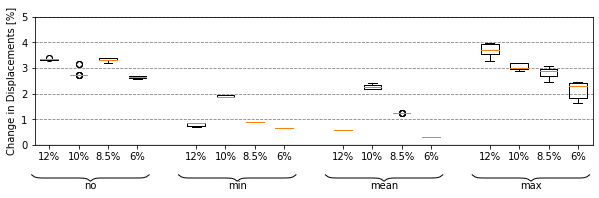

In [9]:
def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y + .05)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.20*yspan, text, ha='center', va='bottom')
        
fig = plt.figure(figsize =(10,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(1)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change in Displacements [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='no']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)
    
    
    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='min']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

    bp_2 = boxplot(results_temp_list,positions = [5,6,7,8],widths = 0.6)
    
    

    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='mean']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

    bp_3 = boxplot(results_temp_list,positions = [10,11,12,13],widths = 0.6)
    
    
    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='max']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

    bp_4 = boxplot(results_temp_list,positions = [15,16,17,18],widths = 0.6)

    
    ylim(0,5)
    ax1.yaxis.grid(color='gray', linestyle='dashed')


    ax1.set_xticks([0,1,2,3, 5,6,7,8, 10,11,12,13, 15,16,17,18])
    ax1.set_xticklabels(['12%','10%','8.5%','6%',
                         '12%','10%','8.5%','6%',
                         '12%','10%','8.5%','6%',
                         '12%','10%','8.5%','6%',])
    
    draw_brace(ax1, (-0.6,3.4),0.8, 'no')
    draw_brace(ax1, (4.4,8.4),0.8, 'min')
    draw_brace(ax1, (9.4,13.4),0.8, 'mean')
    draw_brace(ax1, (14.4,18.4),0.8, 'max')

# Plot - Results Summary

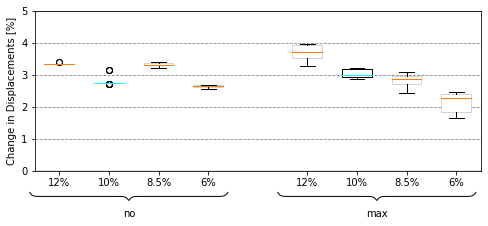

In [44]:
def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y + .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.20*yspan, text, ha='center', va='bottom')
        
fig = plt.figure(figsize =(8,10), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(1)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change in Displacements [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    # bp1
    
    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='no']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

#    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)
    bp_1_10 = boxplot(results_temp_list[0],positions = [1],widths = 0.6)
    bp_1 = boxplot(results_temp_list[1:4],positions = [0,2,3],widths = 0.6, patch_artist=True)
    for box in bp_1['boxes']:
        box.set(color='lightgrey')
        box.set(facecolor = 'white' )
        box.set(edgecolor = 'lightgrey')    
    for median in bp_1_10['medians']:
        median.set_color('cyan')
   
    # bp2
    
    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='max']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

    bp_4_10 = boxplot(results_temp_list[0],positions = [6],widths = 0.6)
    bp_4 = boxplot(results_temp_list[1:4],positions = [5,7,8],widths = 0.6, patch_artist=True)
    for box in bp_4['boxes']:
        box.set(color='lightgrey')
        box.set(facecolor = 'white' )
        box.set(edgecolor = 'lightgrey')
    for median in bp_4_10['medians']:
        median.set_color('cyan')
    
    ylim(0,5)
    ax1.yaxis.grid(color='gray', linestyle='dashed')


    ax1.set_xticks([0,1,2,3, 5,6,7,8])
    ax1.set_xticklabels(['12%','10%','8.5%','6%',
                         '12%','10%','8.5%','6%',])
    
    draw_brace(ax1, (-0.6,3.4),0.5, 'no')
    draw_brace(ax1, (4.4,8.4),0.5, 'max')
    
    fig.savefig(f"{path_plots}/plot_all_intensification_affected_people_change.png",dpi=300)

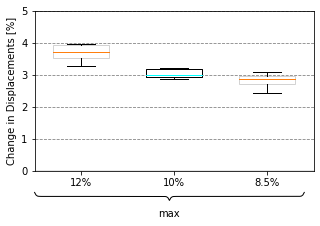

In [8]:
def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y + .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.20*yspan, text, ha='center', va='bottom')
        
fig = plt.figure(figsize =(5,10), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(1)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change in Displacements [%]')
    ax1.axhline(color='gray',linewidth=1.4)
   
    # bp1
    
    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='max']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])

    bp_4_10 = boxplot(results_temp_list[0],positions = [1],widths = 0.6)
    bp_4 = boxplot(results_temp_list[1:4],positions = [0,2],widths = 0.6, patch_artist=True)
    for box in bp_4['boxes']:
        box.set(color='lightgrey')
        box.set(facecolor = 'white' )
        box.set(edgecolor = 'lightgrey')
    for median in bp_4_10['medians']:
        median.set_color('cyan')
    
    ylim(0,5)
    ax1.yaxis.grid(color='gray', linestyle='dashed')


    ax1.set_xticks([0,1,2])
    ax1.set_xticklabels(['12%','10%','8.5%'])
    
    draw_brace(ax1, (-0.5,2.4),0.5, 'max')
    
    fig.savefig(f"{path_plots}/plot_all_intensification_affected_people_change.png",dpi=300)

In [ ]:

def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y + .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.20*yspan, text, ha='center', va='bottom')
        
fig = plt.figure(figsize =(10,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(1)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change in Displacements [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='no']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

#    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)
    bp_1_10 = boxplot(results_temp_list[0],positions = [1],widths = 0.6)
    bp_1 = boxplot(results_temp_list[1:4],positions = [0,2,3],widths = 0.6, patch_artist=True)
    for box in bp_1['boxes']:
        box.set(color='lightgrey')
        box.set(facecolor = 'white' )
        box.set(edgecolor = 'lightgrey')    
    for median in bp_1_10['medians']:
        median.set_color('cyan')
        
    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='min']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

#    bp_2 = boxplot(results_temp_list,positions = [5,6,7,8],widths = 0.6)
    bp_2_10 = boxplot(results_temp_list[0],positions = [6],widths = 0.6)
    bp_2 = boxplot(results_temp_list[1:4],positions = [5,7,8],widths = 0.6, patch_artist=True)
    for box in bp_2['boxes']:
        box.set(color='lightgrey')
        box.set(facecolor = 'white' )
        box.set(edgecolor = 'lightgrey')    
    for median in bp_2_10['medians']:
        median.set_color('cyan')    

    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='mean']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

  #  bp_3 = boxplot(results_temp_list,positions = [10,11,12,13],widths = 0.6)
    bp_3_10 = boxplot(results_temp_list[0],positions = [11],widths = 0.6)
    bp_3 = boxplot(results_temp_list[1:4],positions = [10,12,13],widths = 0.6, patch_artist=True)
    for box in bp_3['boxes']:
        box.set(color='lightgrey')
        box.set(facecolor = 'white' )
        box.set(edgecolor = 'lightgrey')    
    for median in bp_3_10['medians']:
        median.set_color('cyan')
        
    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='max']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

    bp_4_10 = boxplot(results_temp_list[0],positions = [16],widths = 0.6)
    bp_4 = boxplot(results_temp_list[1:4],positions = [15,17,18],widths = 0.6, patch_artist=True)
    for box in bp_4['boxes']:
        box.set(color='lightgrey')
        box.set(facecolor = 'white' )
        box.set(edgecolor = 'lightgrey')
    for median in bp_4_10['medians']:
        median.set_color('cyan')
    
    ylim(0,5)
    ax1.yaxis.grid(color='gray', linestyle='dashed')


    ax1.set_xticks([0,1,2,3, 5,6,7,8, 10,11,12,13, 15,16,17,18])
    ax1.set_xticklabels(['12%','10%','8.5%','6%',
                         '12%','10%','8.5%','6%',
                         '12%','10%','8.5%','6%',
                         '12%','10%','8.5%','6%',])
    
    draw_brace(ax1, (-0.6,3.4),0.8, 'no')
    draw_brace(ax1, (4.4,8.4),0.8, 'min')
    draw_brace(ax1, (9.4,13.4),0.8, 'mean')
    draw_brace(ax1, (14.4,18.4),0.8, 'max')

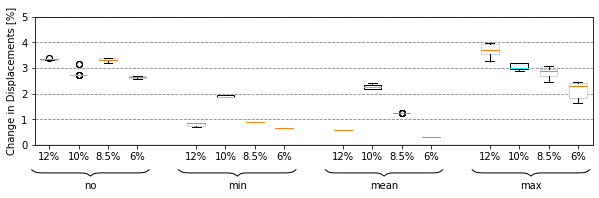

In [3]:
# DEL



def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y + .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.20*yspan, text, ha='center', va='bottom')
        
fig = plt.figure(figsize =(10,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(1)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change in Displacements [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='no']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

#    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)
    bp_1_10 = boxplot(results_temp_list[0],positions = [1],widths = 0.6)
    bp_1 = boxplot(results_temp_list[1:4],positions = [0,2,3],widths = 0.6, patch_artist=True)
    for box in bp_1['boxes']:
        box.set(color='lightgrey')
        box.set(facecolor = 'white' )
        box.set(edgecolor = 'lightgrey')    
    for median in bp_1_10['medians']:
        median.set_color('cyan')
        
    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='min']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

#    bp_2 = boxplot(results_temp_list,positions = [5,6,7,8],widths = 0.6)
    bp_2_10 = boxplot(results_temp_list[0],positions = [6],widths = 0.6)
    bp_2 = boxplot(results_temp_list[1:4],positions = [5,7,8],widths = 0.6, patch_artist=True)
    for box in bp_2['boxes']:
        box.set(color='lightgrey')
        box.set(facecolor = 'white' )
        box.set(edgecolor = 'lightgrey')    
    for median in bp_2_10['medians']:
        median.set_color('cyan')    

    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='mean']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

  #  bp_3 = boxplot(results_temp_list,positions = [10,11,12,13],widths = 0.6)
    bp_3_10 = boxplot(results_temp_list[0],positions = [11],widths = 0.6)
    bp_3 = boxplot(results_temp_list[1:4],positions = [10,12,13],widths = 0.6, patch_artist=True)
    for box in bp_3['boxes']:
        box.set(color='lightgrey')
        box.set(facecolor = 'white' )
        box.set(edgecolor = 'lightgrey')    
    for median in bp_3_10['medians']:
        median.set_color('cyan')
        
    results_temp_list = []
    results_temp = results_ext[results_ext['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']=='max']

    results_temp = results_temp[results_temp['cf_group']==3]
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
    results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

    bp_4_10 = boxplot(results_temp_list[0],positions = [16],widths = 0.6)
    bp_4 = boxplot(results_temp_list[1:4],positions = [15,17,18],widths = 0.6, patch_artist=True)
    for box in bp_4['boxes']:
        box.set(color='lightgrey')
        box.set(facecolor = 'white' )
        box.set(edgecolor = 'lightgrey')
    for median in bp_4_10['medians']:
        median.set_color('cyan')
    
    ylim(0,5)
    ax1.yaxis.grid(color='gray', linestyle='dashed')


    ax1.set_xticks([0,1,2,3, 5,6,7,8, 10,11,12,13, 15,16,17,18])
    ax1.set_xticklabels(['12%','10%','8.5%','6%',
                         '12%','10%','8.5%','6%',
                         '12%','10%','8.5%','6%',
                         '12%','10%','8.5%','6%',])
    
    draw_brace(ax1, (-0.6,3.4),0.8, 'no')
    draw_brace(ax1, (4.4,8.4),0.8, 'min')
    draw_brace(ax1, (9.4,13.4),0.8, 'mean')
    draw_brace(ax1, (14.4,18.4),0.8, 'max')

In [61]:

results_temp_list = []
results_temp = results_ext[results_ext['threshold']==threshold]
results_temp = results_temp[results_temp['tide']=='mean']

results_temp = results_temp[results_temp['cf_group']==3]
results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])


In [62]:
results_temp#_list#[1:3]

,index,Unnamed: 0,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,...,affected_flood_wind,affected_flood_wind_cf,displacements,vulnerability,displacements_dif,displacements_dif_perc,vulnerability_flood_wind,displacements_flood_wind_cf,displacements_flood_wind_cf_dif,displacements_flood_wind_cf_dif_perc_of_tot_disp
117,2,2.0,factualwind880zos065,mean,100,1218170,1437883.0,1136231.0,358652.0,0.0,...,1576822.0,1218170.0,475464.0,0.39031,2705.0,0.5689,0.303245,369405.0,108764.0,22.7459
118,3,3.0,factualwind880zos070,mean,100,1218170,1437883.0,1136231.0,358652.0,0.0,...,1576822.0,1218170.0,475464.0,0.39031,2705.0,0.5689,0.303245,369405.0,108764.0,22.7459
119,4,4.0,factualwind880zos075,mean,100,1218170,1437883.0,1136231.0,358652.0,0.0,...,1576822.0,1218170.0,475464.0,0.39031,2705.0,0.5689,0.303245,369405.0,108764.0,22.7459
120,5,5.0,factualwind880zos080,mean,100,1218170,1437883.0,1136231.0,358652.0,0.0,...,1576822.0,1218170.0,475464.0,0.39031,2705.0,0.5689,0.303245,369405.0,108764.0,22.7459
121,6,6.0,factualwind880zos085,mean,100,1218170,1437883.0,1136231.0,358652.0,0.0,...,1576822.0,1218170.0,475464.0,0.39031,2705.0,0.5689,0.303245,369405.0,108764.0,22.7459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,88,88.0,factualwindzos150,mean,100,1197040,1437880.0,1136228.0,358648.0,0.0,...,1555688.0,1197040.0,467217.0,0.39031,10952.0,2.3441,0.303245,362997.0,115172.0,24.0860
204,89,89.0,factualwindzos155,mean,100,1197040,1437880.0,1136228.0,358648.0,0.0,...,1555688.0,1197040.0,467217.0,0.39031,10952.0,2.3441,0.303245,362997.0,115172.0,24.0860
205,90,90.0,factualwindzos160,mean,100,1197040,1437880.0,1136228.0,358648.0,0.0,...,1555688.0,1197040.0,467217.0,0.39031,10952.0,2.3441,0.303245,362997.0,115172.0,24.0860
206,91,91.0,factualwindzos165,mean,100,1196013,1437880.0,1136228.0,358648.0,0.0,...,1554661.0,1196013.0,466816.0,0.39031,11353.0,2.4320,0.303245,362686.0,115483.0,24.1511


In [173]:
results_temp_list = []
results_temp = results_ext[results_ext['threshold']==threshold]
results_temp = results_temp[results_temp['tide']=='mean']

results_temp = results_temp[results_temp['cf_group']==3]
results_temp_list.append(results_temp[results_temp.scenario.str.contains("880")]['affected_dif_perc'])
results_temp_list.append(results_temp[results_temp.scenario.str.contains("windzos")]['affected_dif_perc'])
results_temp_list.append(results_temp[results_temp.scenario.str.contains("915")]['affected_dif_perc'])
results_temp_list.append(results_temp[results_temp.scenario.str.contains("940")]['affected_dif_perc'])

results_temp_list

[117    0.5689
 118    0.5689
 119    0.5689
 120    0.5689
 121    0.5689
 122    0.5689
 123    0.5689
 124    0.5785
 125    0.5785
 126    0.5785
 127    0.5785
 128    0.5785
 129    0.5785
 130    0.5785
 131    0.5785
 132    0.5785
 133    0.5785
 134    0.5785
 135    0.5785
 136    0.5785
 137    0.5785
 138    0.5785
 Name: affected_dif_perc, dtype: float64, 186    2.1872
 187    2.1872
 188    2.1872
 189    2.1872
 190    2.1872
 191    2.1872
 192    2.1872
 193    2.1872
 194    2.1872
 195    2.1872
 196    2.1872
 197    2.3221
 198    2.3221
 199    2.3221
 200    2.3221
 201    2.3441
 202    2.3441
 203    2.3441
 204    2.3441
 205    2.3441
 206    2.4320
 207    2.4320
 Name: affected_dif_perc, dtype: float64, 140    1.2254
 141    1.2357
 142    1.2357
 143    1.2357
 144    1.2357
 145    1.2406
 146    1.2406
 147    1.2406
 148    1.2406
 149    1.2406
 150    1.2406
 151    1.2406
 152    1.2406
 153    1.2406
 154    1.2406
 155    1.2406
 156    1.2406
 15

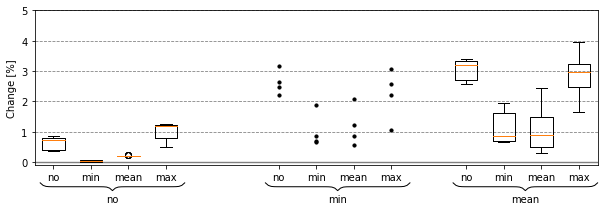

In [121]:
# Change affected people - 100 cm # COMBINED

fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(1)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))
        


    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

   # plt.scatter([6,7,8,9],results_temp_list,color='black',s=10)
    plt.scatter([6,6,6,6],results_temp_list[0],color='black',s=10)
    plt.scatter([7,7,7,7],results_temp_list[1],color='black',s=10)
    plt.scatter([8,8,8,8],results_temp_list[2],color='black',s=10)
    plt.scatter([9,9,9,9],results_temp_list[3],color='black',s=10)

    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    bp_3 = boxplot(results_temp_list,positions = [11,12,13,14],widths = 0.6)

    ylim(-0.1,5)
    
    ax1.set_xticks([0,1,2,3, 6,7,8,9, 11,12,13,14])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.15*yspan, text, ha='center', va='bottom')

    draw_brace(ax1, (-0.35,3.5),0.6, 'no')
    draw_brace(ax1, (5.65,9.5),0.6, 'min')
    draw_brace(ax1, (10.65,14.5),0.6, 'mean')
    
fig.tight_layout()

#fig.savefig(f"{path_plots}/plot_all_tides_affected_people_change_100.png",dpi=300)



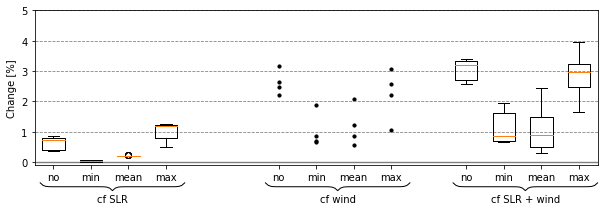

In [53]:
# Change affected people - 100 cm # COMBINED

fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(1)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))
        


    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

   # plt.scatter([6,7,8,9],results_temp_list,color='black',s=10)
    plt.scatter([6,6,6,6],results_temp_list[0],color='black',s=10)
    plt.scatter([7,7,7,7],results_temp_list[1],color='black',s=10)
    plt.scatter([8,8,8,8],results_temp_list[2],color='black',s=10)
    plt.scatter([9,9,9,9],results_temp_list[3],color='black',s=10)

    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    bp_3 = boxplot(results_temp_list,positions = [11,12,13,14],widths = 0.6)

    ylim(-0.1,5)
    
    ax1.set_xticks([0,1,2,3, 6,7,8,9, 11,12,13,14])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.15*yspan, text, ha='center', va='bottom')

    draw_brace(ax1, (-0.35,3.5),0.6, 'cf SLR')
    draw_brace(ax1, (5.65,9.5),0.6, 'cf wind')
    draw_brace(ax1, (10.65,14.5),0.6, 'cf SLR + wind')
    
fig.tight_layout()

#fig.savefig(f"{path_plots}/plot_all_tides_affected_people_change_100.png",dpi=300)



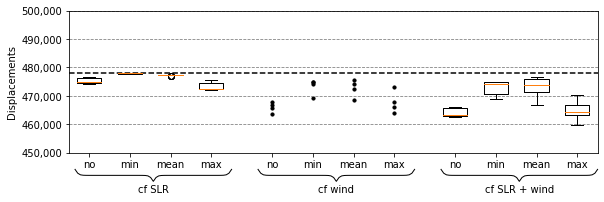

In [64]:
# Displacements - 100 cm


for threshold in [100]:
    
    fig = plt.figure(figsize =(8.5,3.0), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(1, 1, 1)

    ax1.set_ylabel('Displacements')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['displacements']))
        
    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['displacements']))

#    plt.scatter([4.5,5.5,6.5,7.5],results_temp_list,color='black',s=10)
    plt.scatter([4.5,4.5,4.5,4.5],results_temp_list[0],color='black',s=10)
    plt.scatter([5.5,5.5,5.5,5.5],results_temp_list[1],color='black',s=10)
    plt.scatter([6.5,6.5,6.5,6.5],results_temp_list[2],color='black',s=10)
    plt.scatter([7.5,7.5,7.5,7.5],results_temp_list[3],color='black',s=10)
    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['displacements']))
        
    bp_3 = boxplot(results_temp_list,positions = [9,10,11,12],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.011*yspan, text, ha='center', va='bottom')
        
    dif = -441000
    draw_brace(ax1, (-0.35,3.5),dif, 'cf SLR')
    draw_brace(ax1, (4.15,8.0),dif, 'cf wind')
    draw_brace(ax1, (8.65,12.5),dif, 'cf SLR + wind')

    ylim(450_000,500_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    
    ax1.axhline(y=478169, color='black', linestyle='--')
    
    fig.tight_layout()

#    fig.savefig(f"{path_plots}/plot_all_tides_displacements_{threshold}.png",dpi=300)

In [56]:
results[results.scenario=='factualwind']

,Unnamed: 0,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,cf_group
70,70.0,factualwind,max,100,1231871,1430952.0,1129655.0,352882.0,0.0,2
70,70.0,factualwind,mean,100,1200166,1436355.0,1134962.0,357383.0,0.0,2
68,NaN,factualwind,min,100,1200098,1434819.0,1133426.0,356293.0,0.0,2
70,NaN,factualwind,no,100,1213819,1440771.0,1139447.0,361724.0,0.0,2


In [61]:
results_temp_list = []

for tide in ['no']:

    results_temp = results[results['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']==tide]

    factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
    results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
    results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

    results_temp_cf_group = results_temp[results_temp['cf_group']==1]
    results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))
    
    
results_temp[results_temp.cf_group==2]

,Unnamed: 0,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,cf_group,affected_dif,affected_dif_perc
1,NaN,factualwind880,no,100,1207794,1441084.0,1139503.0,361758.0,0.0,2,38249,3.17
24,NaN,factualwind915,no,100,1219113,1434109.0,1132785.0,355389.0,0.0,2,26930,2.21
47,NaN,factualwind940,no,100,1216015,1432725.0,1131428.0,354438.0,0.0,2,30028,2.47
70,NaN,factualwind,no,100,1213819,1440771.0,1139447.0,361724.0,0.0,2,32224,2.65


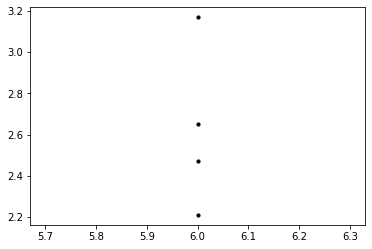

In [52]:
# second boxplot pair
results_temp_list = []


for tide in ['no','min','mean','max']:

    results_temp = results[results['threshold']==threshold]
    results_temp = results_temp[results_temp['tide']==tide]

    factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
    results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
    results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

    results_temp_cf_group = results_temp[results_temp['cf_group']==2]
    results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

plt.scatter([6,6,6,6],results_temp_list[0],color='black',s=10)

In [49]:
results_temp_list

[[3.17, 2.21, 2.47, 2.65],
 [0.71, 0.87, 0.67, 1.88],
 [0.57, 1.22, 0.85, 2.08],
 [3.08, 2.22, 1.05, 2.58]]

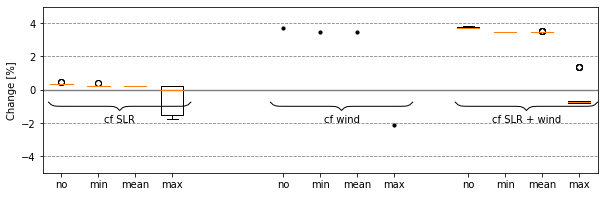

In [20]:
# 400

# Change affected people - 100 cm

def cf_group(x):
    
        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))

fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([400],range(1)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))
        


    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    plt.scatter([6,7,8,9],results_temp_list,color='black',s=10)


    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    bp_3 = boxplot(results_temp_list,positions = [11,12,13,14],widths = 0.6)

    ylim(-5,5)
    
    ax1.set_xticks([0,1,2,3, 6,7,8,9, 11,12,13,14])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.15*yspan, text, ha='center', va='bottom')

    draw_brace(ax1, (-0.35,3.5),0.6, 'cf SLR')
    draw_brace(ax1, (5.65,9.5),0.6, 'cf wind')
    draw_brace(ax1, (10.65,14.5),0.6, 'cf SLR + wind')
    
fig.tight_layout()

#fig.savefig(f"{path_plots}/plot_all_tides_affected_people_change_100.png",dpi=300)

In [12]:
a = results[results.threshold == 400]
a = a[a.tide == 'no']
a

,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,cf_group
0,factual,no,400,485108,1510724.0,1195981.0,378607.0,0.0,0
1,factualwind,no,400,467758,1516680.0,1201936.0,384327.0,0.0,2
2,factualwindzos065,no,400,467758,1516680.0,1201936.0,384327.0,0.0,3
3,factualwindzos070,no,400,467758,1516680.0,1201936.0,384327.0,0.0,3
4,factualwindzos075,no,400,467741,1516680.0,1201936.0,384327.0,0.0,3
5,factualwindzos080,no,400,467741,1516680.0,1201936.0,384327.0,0.0,3
6,factualwindzos085,no,400,467741,1516680.0,1201936.0,384327.0,0.0,3
7,factualwindzos090,no,400,467741,1516680.0,1201936.0,384327.0,0.0,3
8,factualwindzos095,no,400,467741,1516680.0,1201936.0,384327.0,0.0,3
9,factualwindzos100,no,400,467741,1516680.0,1201936.0,384327.0,0.0,3
